In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from torchmetrics.functional import r2_score as r2_loss
from sklearn.model_selection import train_test_split
from itertools import product
from matplotlib.colors import LinearSegmentedColormap

import torch
import torch.nn as nn
import torch.optim as optim
import sys 
import os
import random
from torch.utils.data import DataLoader, TensorDataset
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torchmetrics import MeanSquaredError
# from pytorch_lightning import LightningModule, Trainer
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

sys.path.append(os.path.dirname(os.getcwd())) 
from source.autoencoder import Autoencoder

### Simulate time series with intervals 
Now time series array of train data consists of 3 parts: mean values of daily incidence, low valuee of daily incidence and high values of daily incidence for each day. Therefore, the size of time series array is three times bigger than tmax -- number of simulation days. 

In [97]:
def func_3(daily_incidence_arr):
    mean_daily_incidence = list(np.mean(daily_incidence_arr, axis=0))
    low_daily_incidence = list(np.min(daily_incidence_arr, axis=0))
    high_daily_incidence = list(np.max(daily_incidence_arr, axis=0))
    return mean_daily_incidence+low_daily_incidence+high_daily_incidence

In [102]:
df = pd.read_csv(r'../data/data_ba_100000.csv', index_col=0
                ).reset_index(drop=True)
df.iloc[:,5:]

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.0,7.0,21.0,23.0,30.0,24.0,25.0,23.0,24.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,9.0,19.0,27.0,28.0,29.0,17.0,23.0,22.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,6.0,24.0,26.0,24.0,25.0,23.0,13.0,14.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,7.0,19.0,18.0,23.0,29.0,24.0,17.0,17.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,5.0,17.0,21.0,24.0,21.0,32.0,30.0,19.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,0.0,732.0,2626.0,6148.0,10861.0,14052.0,13791.0,12111.0,9583.0,7215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71996,0.0,624.0,2312.0,5437.0,10000.0,13680.0,13792.0,12226.0,9968.0,7840.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71997,0.0,765.0,2617.0,6139.0,10572.0,13954.0,13728.0,12027.0,9572.0,7461.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71998,0.0,582.0,1954.0,4812.0,9340.0,12980.0,13923.0,12784.0,10190.0,8052.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
df = pd.read_csv(r'../data/data_ba_100000.csv', index_col=0
                ).reset_index(drop=True)


new_c = df.iloc[:,5:].groupby(df.index//10).apply(lambda x: func_3(x.values))
df = pd.concat([df.iloc[::10,:5].reset_index(drop=True),
                pd.DataFrame(new_c.tolist())], axis=1)
tmax=150
df.columns = ['beta','gamma','delta','init_inf_frac','alpha']+\
              ['incidence_' + str(d) for d in range(tmax)] + \
  ['low_incidence_' + str(d) for d in range(tmax)] + \
  ['high_incidence_' + str(d) for d in range(tmax)]
#df.to_csv('../data/ba_interval_dataset_7200.csv')
df

,beta,gamma,delta,init_inf_frac,alpha,incidence_0,incidence_1,incidence_2,incidence_3,incidence_4,...,high_incidence_140,high_incidence_141,high_incidence_142,high_incidence_143,high_incidence_144,high_incidence_145,high_incidence_146,high_incidence_147,high_incidence_148,high_incidence_149
0,0.10,0.3,0.2,0.0001,0.20,0.0,7.8,20.1,22.4,26.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.10,0.3,0.2,0.0001,0.21,0.0,10.1,23.5,28.9,32.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.10,0.3,0.2,0.0001,0.22,0.0,11.5,22.9,30.5,30.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.10,0.3,0.2,0.0001,0.23,0.0,8.4,22.2,32.3,31.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.10,0.3,0.2,0.0001,0.24,0.0,12.4,25.5,30.5,31.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.99,0.3,0.2,0.0001,0.95,0.0,539.2,1500.4,2994.9,5383.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7196,0.99,0.3,0.2,0.0001,0.96,0.0,596.6,1653.8,3445.3,6255.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7197,0.99,0.3,0.2,0.0001,0.97,0.0,614.8,1833.0,3967.9,7235.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7198,0.99,0.3,0.2,0.0001,0.98,0.0,645.0,2087.0,4727.1,8582.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
df = pd.read_csv('../data/ba_interval_dataset_7200.csv', index_col=0)
network_type = 'ba'
tmax = int((df.values.shape[1] - 5)/3) # number of simulation days
# 5 - number of parameters of the network model
df['ts'] = df[['incidence_' + str(day_index) for day_index in range(tmax)] + \
              ['low_incidence_' + str(day_index) for day_index in range(tmax)] + \
              ['high_incidence_' + str(day_index) for day_index in range(tmax)]].values.tolist()
data = df[['beta', 'alpha', 'ts']]

In [118]:
print(r'Диапазон параметров beta:[{}, {}], alpha:[{}, {}]'.format(df['beta'].min(), df['beta'].max(),
                                                                             df['alpha'].min(),
                                                                             df['alpha'].max()))

Диапазон параметров beta:[0.1, 0.9899999999999995], alpha:[0.2, 0.9900000000000008]


In [119]:
'''
X_train, X_test, y_train, y_test =  train_test_split(data.drop(columns=['ts']), 
                                                     data.ts.values, 
                                                     test_size=0.2, 
                                                     random_state=42)
'''
X = data.drop(columns=['ts'])#[['file']]
y = data['ts']

X_train, X_test = train_test_split(X, test_size=2400, 
                                   random_state=42, stratify=None)
y_train = y.loc[X_train.index].values
y_test = y.loc[X_test.index].values

X_train, X_test = X_train.values, X_test.values

In [120]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)

In [121]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [122]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

### Autoencoder

In [123]:
def predict(model, input):
    custom_data_tensor = torch.tensor(input, dtype=torch.float32)
    custom_data_tensor = custom_data_tensor.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(custom_data_tensor)
    return pred.detach().cpu()

def train(model, n_epochs, train_loader, criterion, optimizer, scheduler=None):
    for epoch in tqdm(range(n_epochs)):
        model.train()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            
            loss = criterion(pred, y_batch.to(device))

            loss.backward()
            optimizer.step()

            if scheduler != None:
                scheduler.step()

def test(model, X_test, y_test):
    r2_sum = []
    for (x, y) in zip(X_test, y_test):
        with torch.no_grad():
            model.eval()
            pred = predict(model, x)
            r2_sum.append(r2_score(y, pred))
    print(f"R2 Score: {np.array(r2_sum).mean()}")

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def interval_ae_loss(pred, target, theta_1=1.0, theta_2=1.0, theta_3=1.0):
    """
    Custom loss for interval-aware autoencoder.
    """
    # Split the prediction into mean, lower bound, upper bound
    mean_pred, lb_pred, ub_pred = torch.chunk(pred, 3, dim=1)

    # Squeeze last dimension if needed
    mean_pred = mean_pred.squeeze(-1)
    # print(mean_pred.size())
    lb_pred = lb_pred.squeeze(-1)
    ub_pred = ub_pred.squeeze(-1)
    # Ensure target shape matches
    target = target.squeeze(-1) if target.ndim == 2 else target

    # print(target.size())

    # Mean squared error for the mean prediction
    mean_loss = torch.nn.functional.mse_loss(pred, target)

    # Bound loss
    bound_loss = torch.mean(torch.relu(lb_pred - mean_pred) + torch.relu(mean_pred - ub_pred))

    # Interval constraint loss
    interval_loss = torch.mean(torch.relu(lb_pred - ub_pred))

    total_loss = theta_1 * mean_loss + theta_2 * bound_loss + theta_3 * interval_loss
    return total_loss


In [124]:
arr = torch.randn(16, 45)
mean, low, high = torch.chunk(arr, 3, dim=1)
print(mean.size())
mean = mean.squeeze(-1)
print(mean.size())

torch.Size([16, 15])
torch.Size([16, 15])


In [125]:
def train(
    model,
    n_epochs,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler=None,
    patience=5,
    delta=0,
    device='cpu'
):
    best_loss = float('inf')
    counter = 0
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            pred = model(X_batch.to(device))
            loss = criterion(pred, y_batch.to(device))
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation on test/validation set
        model.eval()
        test_total_loss = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                pred_test = model(X_test.to(device))
                loss_test = criterion(pred_test, y_test.to(device))
                test_total_loss += loss_test.item()

        avg_test_loss = test_total_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}, Train loss: {avg_train_loss:.4f}, Test loss: {avg_test_loss:.4f}")

        if avg_test_loss < 1000:
            break

        # Early stopping logic
        # if avg_train_loss < best_loss - delta:
        #     best_loss = avg_train_loss
        #     counter = 0
        # else:
        #     counter += 1

        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break
    return train_losses, test_losses


#### AE train

In [126]:
hidden_size = 256
latent_size = 32
n_epochs = 100

mse_cr = interval_ae_loss
r2_cr = r2_loss
ae = Autoencoder(input_size=2, hidden_size=hidden_size, latent_size=latent_size, output_size=3*tmax).to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3, weight_decay=5e-4)
# lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=25, T_mult=1, eta_min=1e-6)

In [127]:
train_losses, test_losses = train(model=ae,
        n_epochs=100,   # reduce for faster search, or keep as n_epochs
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=mse_cr,
        optimizer=optimizer,
        scheduler=None,      # or your scheduler if needed
        patience=5,
        delta=0,
        device=device)

Epoch 1, Train loss: 338445.2728, Test loss: 183563.8751
Epoch 2, Train loss: 96590.1685, Test loss: 55912.7827
Epoch 3, Train loss: 47981.8770, Test loss: 40708.3585
Epoch 4, Train loss: 37491.1768, Test loss: 31015.3032
Epoch 5, Train loss: 26923.6867, Test loss: 26936.3201
Epoch 6, Train loss: 20810.8547, Test loss: 17030.5121
Epoch 7, Train loss: 19148.4161, Test loss: 19782.8431
Epoch 8, Train loss: 14641.2913, Test loss: 23762.5013
Epoch 9, Train loss: 15404.7094, Test loss: 14794.2462
Epoch 10, Train loss: 11398.8183, Test loss: 15034.1579
Epoch 11, Train loss: 9572.4782, Test loss: 8564.1791
Epoch 12, Train loss: 7687.0737, Test loss: 7354.3100
Epoch 13, Train loss: 7665.2157, Test loss: 12238.0318
Epoch 14, Train loss: 6835.9288, Test loss: 6996.1667
Epoch 15, Train loss: 5340.8229, Test loss: 5541.9101
Epoch 16, Train loss: 4727.7287, Test loss: 4143.0557
Epoch 17, Train loss: 5053.3666, Test loss: 5775.6095
Epoch 18, Train loss: 5059.8891, Test loss: 7259.9807
Epoch 19, Trai

#### AE test

In [135]:
test(ae, X_test, y_test)

R2 Score: 0.9625473514944315


#### AE save/load model

In [133]:
torch.save(ae, '../models/autoencoder_interval_barabasi_100k_n.pt')

In [134]:
# Saving 
# torch.save(ae, '../models/autoencoder_interval_barabasi_100k.pt')

# Loading
ae = torch.load('../models/autoencoder_interval_barabasi_100k_n.pt', weights_only=False)
ae.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): SiLU(inplace=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU(inplace=True)
    (4): Linear(in_features=256, out_features=450, bias=True)
  )
)

#### AE plot result

In [136]:
def plot_test_with_intervals(params, gt, fontsize=14):
    gt = np.array(gt)
    mean_index = range(tmax)
    low_index = range(tmax, 2*tmax)
    high_index = range(2*tmax, 3*tmax)
    surrogate_sim = predict(ae, params).numpy()
    r2 = r2_score(gt, surrogate_sim)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(gt[mean_index], label='Network model', marker='o', color='OrangeRed')
    ax.fill_between(np.linspace(0, tmax, tmax), gt[low_index], gt[high_index],
                    alpha = 0.5, color='OrangeRed', label='Network model interval')
    ax.plot(surrogate_sim[mean_index], lw=3, color='RoyalBlue', label='Surrogate model')
    ax.fill_between(np.linspace(0, tmax, tmax), 
                    surrogate_sim[low_index], 
                    surrogate_sim[high_index],
                    alpha = 0.5, color='RoyalBlue', label='Surrogate model interval')

    ax.set_xlabel('Days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=1.2*fontsize)
    ax.grid()
    return fig

[0.4  0.59]


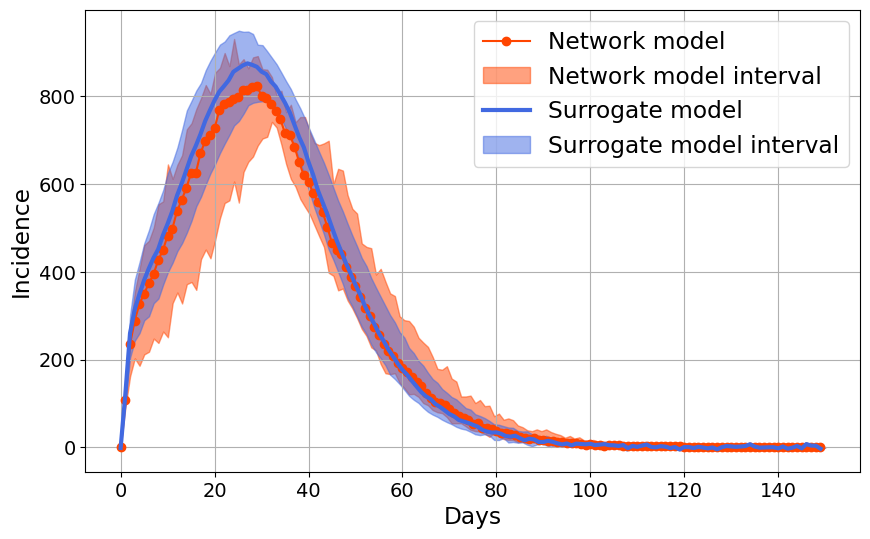

In [137]:
for _ in range(1):
    index = random.randint(0, len(y_test)-1)
    index = 7
    fig = plot_test_with_intervals(X_test[index], y_test[index])
    print(X_test[index])
    # fig.savefig(r'../figures/ae_interval_simulation_{}.png'.format(index), 
    #             dpi=600,
    #             bbox_inches='tight')
    # fig.savefig(r'../figures/ae_interval_simulation_{}.pdf'.format(index),
    #             bbox_inches='tight')

#### AE interval colormap

In [138]:
R2_test = []
for index, params in enumerate(X_test):
    prediction = predict(ae, params)
    R2_test.append(r2_score(prediction, y_test[index]))

In [139]:
np.mean(R2_test)

np.float64(0.9733516338715951)

In [15]:
network_type

'ba'

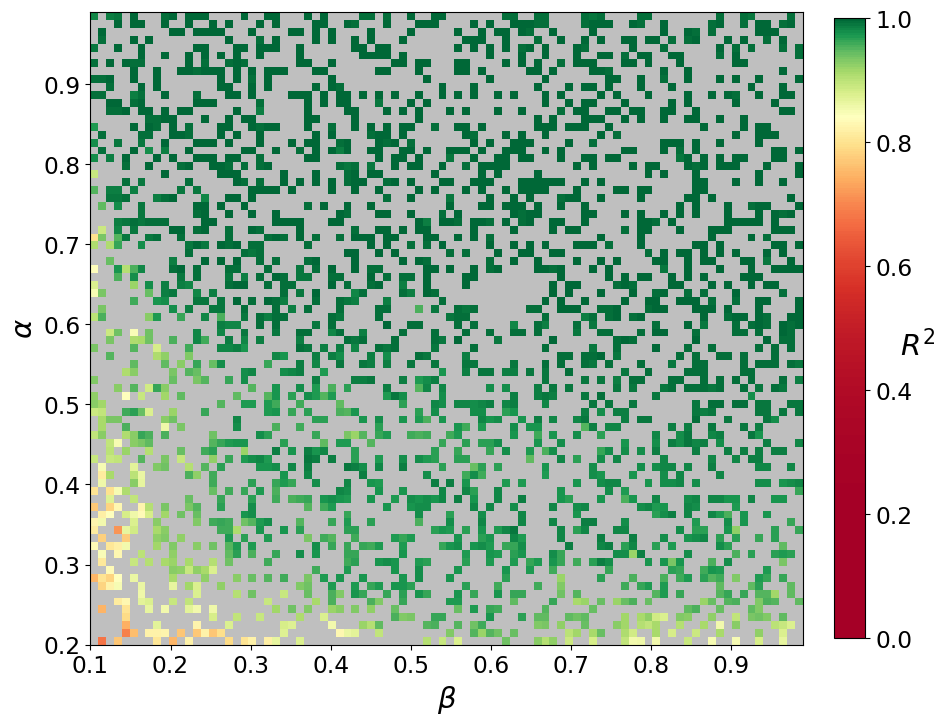

In [140]:
param_1_vals = np.sort(np.unique(np.concatenate((X_train[:,0], X_test[:,0]))))
param_2_vals = np.sort(np.unique(np.concatenate((X_train[:,1], X_test[:,1]))))

# Create empty grid
heatmap = np.full((len(param_2_vals), len(param_1_vals)), np.nan)
for (p1, p2), r2 in zip(X_test, R2_test):
    i = np.where(param_2_vals == p2)[0][0]
    j = np.where(param_1_vals == p1)[0][0]
    heatmap[i, j] = r2

# Mask X_train locations
train_mask = np.zeros_like(heatmap, dtype=bool)
for (p1, p2) in X_train:
    i = np.where(param_2_vals == p2)[0]
    j = np.where(param_1_vals == p1)[0]
    if len(i) and len(j):
        train_mask[i[0], j[0]] = True

masked_heatmap = np.ma.masked_array(heatmap, mask=train_mask)

def nonlinear_norm(x):
    # Быстрый рост от 0 до 0.8 (линейный)
    # Плавный переход от 0.8 до 0.95 (квадратный корень)
    # Очень медленный рост от 0.95 до 1 (логарифмический)
    return x**4

# Get plasma colormap and create nonlinear version
plasma = plt.cm.RdYlGn
colors = plasma(np.linspace(0, 1, 256))
new_colors = colors[(nonlinear_norm(np.linspace(0, 1, 256)) * 255).astype(int)]
nonlinear_cmap = LinearSegmentedColormap.from_list('nonlinear_plasma', new_colors)

# Plot
fontsize = 14
fig, ax = plt.subplots(figsize=(10, 10))
nonlinear_cmap.set_bad('gray', alpha=0.5)  # train in gray
img = ax.imshow(masked_heatmap, origin='lower', cmap=nonlinear_cmap, vmin=0, vmax=1,
                 extent=[param_1_vals[0], param_1_vals[-1], param_2_vals[0], param_2_vals[-1]],
                 aspect='equal')
cbar = fig.colorbar(img, ax=ax, label='$R^2$', fraction=0.04, pad=0.04)
cbar.ax.yaxis.label.set_size(1.5*fontsize)  # colorbar label fontsize
cbar.ax.yaxis.label.set_rotation(0)
cbar.ax.tick_params(labelsize=1.2*fontsize)    # colorbar tick labels fontsize
ax.set_xlabel(r'$\beta$', fontsize=1.5*fontsize)
ax.set_ylabel(r'$\alpha$', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=1.2*fontsize)
# ax.set_title(r'$R^2$ Colormap (Gray for X_train, Color for X_test)')
fig.savefig(r'../figures/ae_{}_network_colormap_interval_estimation.png'.format(network_type), 
            dpi=600, bbox_inches='tight')
fig.savefig(r'../figures/ae_{}_network_colormap_interval_estimation.pdf'.format(network_type), 
            bbox_inches='tight')

In [141]:
test_indices = [11,7,1,15]
for elem in test_indices:
    print(X_test[elem])

[0.35 0.44]
[0.4  0.59]
[0.41 0.71]
[0.37 0.75]


#### AE subplots

In [142]:
qw = pd.read_csv(r'../data/data_ba_100000.csv', index_col=0
                ).reset_index(drop=True)
qw['group'] = qw.index//10
mtr, mtest = train_test_split(X, test_size=2400, 
                                   random_state=42, stratify=None)
mtest.index
mtr.index

Index([2972, 6226, 1684, 4680, 1338, 3102, 6678, 5223, 3939, 2258,
       ...
       5334,  466, 6265, 5734, 3092, 3772, 5191, 5226, 5390,  860],
      dtype='int64', length=4800)

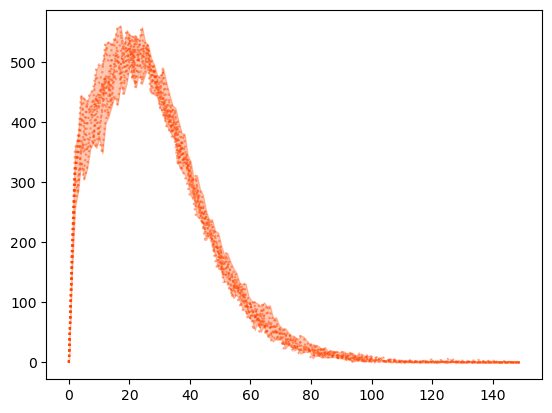

In [143]:
ii=670
real_idx = mtest.iloc[ii].name
part = qw[qw.group==real_idx].iloc[:,5:-1]
part.columns = part.columns.astype(int)
plt.plot(part.T, color='OrangeRed', ls=':', alpha=.5,
                 label=['Network model, trajectory']+['']*9);

gt = np.array(y_test[ii])

mean_index = range(tmax)
low_index = range(tmax, 2*tmax)
high_index = range(2*tmax, 3*tmax)

plt.fill_between(np.linspace(0, tmax, tmax)[:cut], 
                          gt[low_index][:cut], gt[high_index][:cut],
                    alpha = 0.3, color='OrangeRed', 
                          label='Network model interval')

In [76]:
real_idx

np.int64(6747)

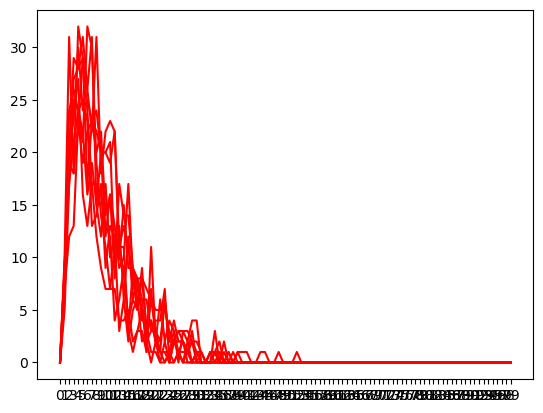

In [95]:
plt.plot(ba2.iloc[0:10,5:105].T, color='red');

In [92]:
ba2 = pd.read_csv(r'../data/data_ba_100000.csv',
                index_col=0)
ba2.iloc[0:10]

,beta,gamma,delta,init_inf_frac,init_rec_frac,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.1,0.3,0.2,0.0001,0.2,0.0,7.0,21.0,23.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1,0.3,0.2,0.0001,0.2,0.0,9.0,19.0,27.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.1,0.3,0.2,0.0001,0.2,0.0,6.0,24.0,26.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1,0.3,0.2,0.0001,0.2,0.0,7.0,19.0,18.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.1,0.3,0.2,0.0001,0.2,0.0,5.0,17.0,21.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.1,0.3,0.2,0.0001,0.2,0.0,7.0,12.0,13.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.1,0.3,0.2,0.0001,0.2,0.0,9.0,20.0,29.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.1,0.3,0.2,0.0001,0.2,0.0,9.0,17.0,25.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.1,0.3,0.2,0.0001,0.2,0.0,10.0,31.0,18.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.1,0.3,0.2,0.0001,0.2,0.0,9.0,21.0,24.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
ba = pd.read_csv(r'../data/ba-network-100k_dataset.csv',
                index_col=0)
ba.iloc[:]

,beta,gamma,delta,init_inf_frac,alpha,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.10,0.3,0.2,0.0001,0.20,0.0,7.0,17.0,31.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.10,0.3,0.2,0.0001,0.21,0.0,10.0,17.0,36.0,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.10,0.3,0.2,0.0001,0.22,0.0,12.0,18.0,20.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.10,0.3,0.2,0.0001,0.23,0.0,9.0,24.0,28.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.10,0.3,0.2,0.0001,0.24,0.0,8.0,8.0,9.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,0.99,0.3,0.2,0.0001,0.95,0.0,580.0,1503.0,3027.0,5325.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7196,0.99,0.3,0.2,0.0001,0.96,0.0,562.0,1531.0,3261.0,6013.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7197,0.99,0.3,0.2,0.0001,0.97,0.0,560.0,1519.0,3304.0,6409.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7198,0.99,0.3,0.2,0.0001,0.98,0.0,628.0,2021.0,4631.0,8496.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


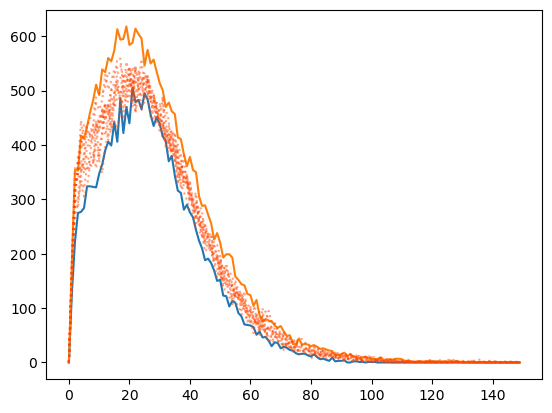

In [80]:
rq = pd.read_csv(r'../data/network_model_interval_dataset_7200.csv',
                 index_col=0).iloc[:,5:]
plt.plot(rq.iloc[real_idx, range(tmax, 2*tmax)].values.T)
plt.plot(rq.iloc[real_idx, range(2*tmax, 3*tmax)].values.T)

part = qw[qw.group==real_idx].iloc[:,5:-1]
part.columns = part.columns.astype(int)
plt.plot(part.T, color='OrangeRed', ls=':', alpha=.5,
                 label=['Network model, trajectory']+['']*9);

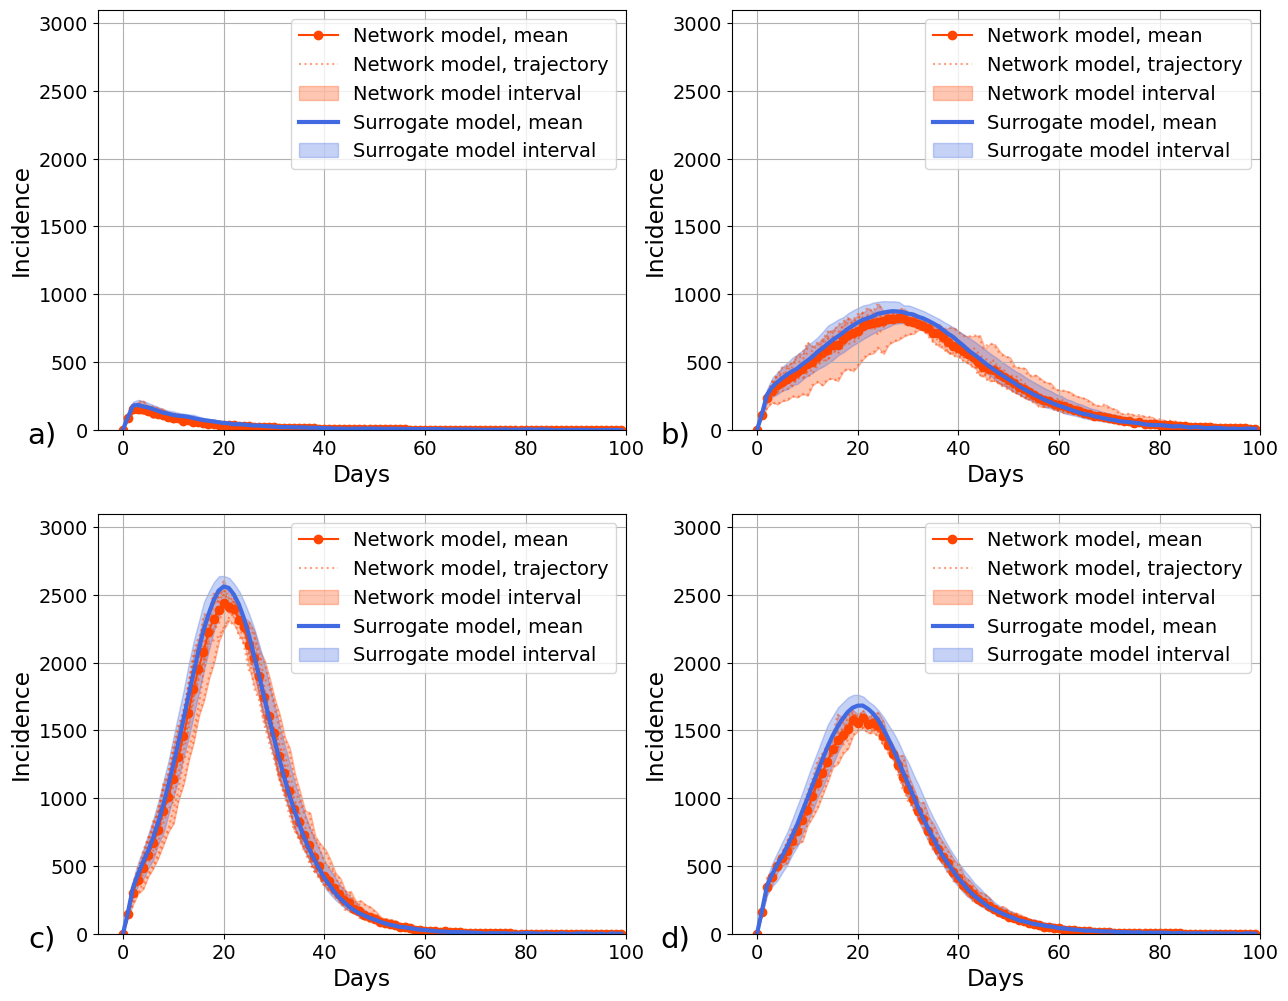

In [161]:
fontsize = 14
test_indices = [1100,7,1,150]
                
rows = 2
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(15, 12))

labels = ['a)', 'b)', 'c)', 'd)']
counter = 0
mean_index = range(tmax)
low_index = range(tmax, 2*tmax)
high_index = range(2*tmax, 3*tmax)
cut = 100

for row in range(rows):
    for col in range(cols):
        surrogate_sim = predict(ae, X_test[test_indices[counter]]).numpy()
        r2 = r2_score(y_test[test_indices[counter]], surrogate_sim)

        gt = np.array(y_test[test_indices[counter]])
        
        ax[row][col].plot(gt[mean_index][:cut], label='Network model, mean', 
                          marker='o', color='OrangeRed')
        
        real_idx = mtest.iloc[test_indices[counter]].name
        part = qw[qw.group==real_idx].iloc[:,5:-1]
        part.columns = part.columns.astype(int)
        ax[row][col].plot(part.T, color='OrangeRed', ls=':', alpha=.5,
                         label=['Network model, trajectory']+['']*9)
    
        ax[row][col].fill_between(np.linspace(0, tmax, tmax)[:cut], 
                                  gt[low_index][:cut], gt[high_index][:cut],
                            alpha = 0.3, color='OrangeRed', 
                                  label='Network model interval')
        
        ax[row][col].plot(surrogate_sim[mean_index][:cut], lw=3, 
                          color='RoyalBlue', label='Surrogate model, mean')
        ax[row][col].fill_between(np.linspace(0, tmax, tmax)[:cut], 
                    surrogate_sim[low_index][:cut], 
                    surrogate_sim[high_index][:cut],
                    alpha = 0.3, color='RoyalBlue', 
                                  label='Surrogate model interval')

        ax[row][col].set_xlabel('Days', fontsize=1.2*fontsize)
        ax[row][col].set_ylabel('Incidence', fontsize=1.2*fontsize)
        ax[row][col].set_ylim(0, 3100)
        ax[row][col].set_xlim(-5, cut)
        ax[row][col].tick_params(axis='both', which='major', labelsize=fontsize)
        ax[row][col].legend(fontsize=fontsize)
        ax[row][col].grid()
        
        # Add subplot label outside the top-left corner
        ax[row][col].annotate(labels[counter], xy=(0, 0), xycoords='axes fraction',
                              xytext=(-30, -10), textcoords='offset points',
                              fontsize=1.5*fontsize, ha='right', va='baseline')
        
        counter += 1


fig.savefig('../figures/ae_ba_network_subplots_interval_estimation.pdf', bbox_inches='tight')
fig.savefig('../figures/ae_ba_network_subplots_interval_estimation.png', dpi=600, bbox_inches='tight')
